# Followers Graphs

The goal here is to construct a follower graph on Mastodon using the `GET /api/v1/directory HTTP/1.1` endpoint

## Setup

In [260]:
import pandas as pd
import numpy as np
import requests as re
import time
import os
import sqlite3
import json
import random
from mastodon import Mastodon
import networkx as nx

import matplotlib.pyplot as plt

### Pandas Set up

In [ ]:
# pandas options
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'

## Check how the followers thing is working

According to https://docs.joinmastodon.org/methods/directory/

The `GET /api/v1/directory HTTP/1.1` endpoint returns "A directory of profiles that your website is aware of."

I think this is exactly what we would want!



In [33]:
offset = 80

In [34]:
req_stem = "https://hci.social/api/v1/directory?limit=80&local=true&order=new&offset={offset}"
req_query = req_stem.format(offset=offset)
r = re.get(req_query)


try:
    profiles = r.json()
except Exception as e:
    print(e, offset)

In [35]:
print(profiles[0])

{'id': '109467428920172086', 'username': 'AKWILL', 'acct': 'AKWILL', 'display_name': 'Alicia', 'locked': False, 'bot': False, 'discoverable': True, 'group': False, 'created_at': '2022-12-06T00:00:00.000Z', 'note': '<p>PhD Candidate at UMSI studying mental health informatics, health equity, and UX practices. RPCV, knitter, lizard/cat mom, she/they. Probably proud of you 🌈💅🥳</p>', 'url': 'https://hci.social/@AKWILL', 'uri': 'https://hci.social/users/AKWILL', 'avatar': 'https://hci.social/avatars/original/missing.png', 'avatar_static': 'https://hci.social/avatars/original/missing.png', 'header': 'https://hci.social/headers/original/missing.png', 'header_static': 'https://hci.social/headers/original/missing.png', 'followers_count': 2, 'following_count': 5, 'statuses_count': 0, 'last_status_at': None, 'noindex': False, 'emojis': [], 'roles': [], 'fields': []}


In [36]:
len(profiles)

80

### Some helper functions

In [62]:
def select_relevant_fields(iterable): 
    """
    Just a map to pull certain things out of the json
    
    """
    smaller_json = list(map(lambda x: 
                            dict(
                                id=x["id"],
                                acct=x["acct"],
                                url=x["url"], # so we can tell which server!
                                created_at=x["created_at"],
                                followers_count=x["followers_count"],
                                following_count=x["following_count"],
                                statuses_count=x["statuses_count"],
                                last_status_at=x["last_status_at"]
                            ), 
                            iterable
                           )
                       )
    
    # add the server
    new_list = []
    for a_dict in smaller_json:
        # add the server name
        
        # need both because there are different urls for local versus not
        a_dict["instance"] = a_dict["url"].split("@")[0].split("/users/")[0]
        
        new_list.append(a_dict)
   
    return new_list

## Do it again!

In [205]:
def pull_profiles(file_path="data/profiles/", local_only=True, offset=0, stride=80, write=True):
    """
    
    """
    profiles_df = pd.DataFrame()
    chunk_df = pd.DataFrame()

    req_stem = "https://hci.social/api/v1/directory?limit=80&local={local_only}&order=new&offset={offset}"
    req_query = req_stem.format(offset=offset, local_only="true" if local_only else "false")
    r = re.get(req_query)

    try:
        profiles = r.json()
    except Exception as e:
        print(e, offset)

    ii = 0

    while len(profiles) > 0:
        # keep going until you run out!

        this_profiles_chunk = pd.DataFrame(select_relevant_fields(profiles))

        # TODO: Don't concat these because we don't want huge CSVs! 
        # the newest thing is at the top, so concat old to the new
        profiles_df = pd.concat([this_profiles_chunk, profiles_df], axis=0)

        # Dataframe for 10 interations
        chunk_df = pd.concat([this_profiles_chunk, chunk_df], axis=0)

        # find out your new min_id
        most_recent_created_time = this_profiles_chunk["created_at"].max()

        if (ii + 1) % 10 == 0:
            print("caching results") 
            if write:
                chunk_df.to_csv(file_path + "{}_profile_chunk_{}.csv".format("local" if local_only else "global", ii), index=False)
            chunk_df = pd.DataFrame()

        ii += 1
        offset += stride

        print("I am so proud of you, the last profile was created at {}".format(most_recent_created_time))

        # don't get booted off the API
        time.sleep(1)

        # make another call
        req_query = req_stem.format(offset=offset, local_only="true" if local_only else "false")
        r = re.get(req_query)

        try:
            profiles = r.json()
        except Exception as e:
            print(e, offset)


    print("DONE! You did so good!!")
            
    if write:
        profiles_df.to_csv(file_path + "hci_social_profiles_{}.csv".format("local" if local_only else "global"), index=False)
    
    return profiles_df


In [206]:
local_profiles = pull_profiles(local_only=True)

I am so proud of you, the last profile was created at 2023-11-09T00:00:00.000Z
I am so proud of you, the last profile was created at 2022-12-06T00:00:00.000Z
I am so proud of you, the last profile was created at 2022-11-18T00:00:00.000Z
I am so proud of you, the last profile was created at 2022-11-11T00:00:00.000Z
I am so proud of you, the last profile was created at 2022-11-07T00:00:00.000Z
I am so proud of you, the last profile was created at 2022-11-04T00:00:00.000Z
I am so proud of you, the last profile was created at 2022-10-31T00:00:00.000Z
I am so proud of you, the last profile was created at 2022-10-27T00:00:00.000Z
I am so proud of you, the last profile was created at 2022-05-12T00:00:00.000Z
DONE! You did so good!!


In [65]:
# this might give us all? like mastodon.social?
all_profiles = pull_profiles(local_only=False)

I am so proud of you, the last profile was created at 2023-11-15T00:00:00.000Z
I am so proud of you, the last profile was created at 2023-11-15T00:00:00.000Z
I am so proud of you, the last profile was created at 2023-11-14T00:00:00.000Z
I am so proud of you, the last profile was created at 2023-11-14T00:00:00.000Z
I am so proud of you, the last profile was created at 2023-11-14T00:00:00.000Z
I am so proud of you, the last profile was created at 2023-11-14T00:00:00.000Z
I am so proud of you, the last profile was created at 2023-11-13T00:00:00.000Z
I am so proud of you, the last profile was created at 2023-11-13T00:00:00.000Z
I am so proud of you, the last profile was created at 2023-11-12T00:00:00.000Z
caching results
I am so proud of you, the last profile was created at 2023-11-12T00:00:00.000Z
I am so proud of you, the last profile was created at 2023-11-12T00:00:00.000Z
I am so proud of you, the last profile was created at 2023-11-11T00:00:00.000Z
I am so proud of you, the last profi

KeyboardInterrupt: 

Too many account here! I think instead, we should pick a big, but not huge instance and do it there!

## Compute following graph!

In [207]:
df = pd.read_csv("data/profiles/hci_social_profiles_local.csv")

In [208]:
df.head(10)

,id,acct,url,created_at,followers_count,following_count,statuses_count,last_status_at,instance
0,108286624813793740,cqz,https://hci.social/@cqz,2022-05-12T00:00:00.000Z,48,20,24,2023-11-03,https://hci.social/
1,108286142941695868,Gillian,https://hci.social/@Gillian,2022-05-12T00:00:00.000Z,368,271,36,2022-12-23,https://hci.social/
2,108286014897638184,AndreaHCI,https://hci.social/@AndreaHCI,2022-05-11T00:00:00.000Z,13,9,1,2022-12-26,https://hci.social/
3,108285815791532398,izd,https://hci.social/@izd,2022-05-11T00:00:00.000Z,39,22,37,2023-10-12,https://hci.social/
4,108285424167487793,shirinfeiz,https://hci.social/@shirinfeiz,2022-05-11T00:00:00.000Z,12,20,0,NaN,https://hci.social/
5,108285175735137681,Helena,https://hci.social/@Helena,2022-05-11T00:00:00.000Z,93,89,11,2023-02-27,https://hci.social/
6,108284677476769450,mlam,https://hci.social/@mlam,2022-05-11T00:00:00.000Z,100,77,7,2023-04-12,https://hci.social/
7,108284650613162617,sukrit,https://hci.social/@sukrit,2022-05-11T00:00:00.000Z,291,255,270,2023-11-16,https://hci.social/
8,108284640329969016,parastoo,https://hci.social/@parastoo,2022-05-11T00:00:00.000Z,85,28,7,2023-09-09,https://hci.social/
9,108284496969846045,masmart,https://hci.social/@masmart,2022-05-11T00:00:00.000Z,118,218,26,2023-08-09,https://hci.social/


#### Show that we can pull followers/following

In [104]:
def select_relevant_following_fields(iterable): 
    """
    Just a map to pull certain things out of the json
    
    """
    smaller_json = list(map(lambda x: 
                            dict(
                                id=x["id"],
                                acct=x["acct"],
                                url=x["url"], # so we can tell which server!
                                created_at=x["created_at"],
                                followers_count=x["followers_count"],
                                following_count=x["following_count"],
                                statuses_count=x["statuses_count"],
                                last_status_at=x["last_status_at"]
                            ), 
                            iterable
                           )
                       )
    
    # add the server
    new_list = []
    for a_dict in smaller_json:
        # add the server name
        
        # need both because there are different urls for local versus not
        a_dict["instance"] = a_dict["url"].split("@")[0].split("/users/")[0]
        
        new_list.append(a_dict)
   
    return new_list

In [157]:
id = df.iloc[0]["id"]
id

108286624813793740

In [134]:
this_user_followers = []

In [135]:
followers_string = "https://hci.social/api/v1/accounts/{id}/followers?limit={limit}"

In [136]:
followers_query = followers_string.format(id=id, limit=80)
r = re.get(followers_query)

In [137]:
try:
    follower_list = r.json()
except Exception as e:
    print(e, offset)

this_user_followers.extend(follower_list)

In [138]:
len(this_user_followers)

80

In [126]:
str(r.headers["Link"]).split('>; rel="next",')[0].strip("<")

'https://hci.social/api/v1/accounts/108286142941695868/followers?limit=80&max_id=151166'

In [139]:
r = re.get(str(r.headers["Link"]).split('>; rel="next",')[0].strip("<"))

try:
    follower_list = r.json()
except Exception as e:
    print(e, offset)

    
this_user_followers.extend(follower_list)

In [140]:
len(this_user_followers)

160

In [143]:
r = re.get(str(r.headers["Link"]).split('>; rel="next",')[0].strip("<"))

try:
    follower_list = r.json()
except Exception as e:
    print(e, offset)

    
this_user_followers.extend(follower_list)

In [144]:
len(this_user_followers)

240

In [184]:
def get_this_user_network(user_id, which="following", verbose=False):
    """
    Either get followers or following for a specific ID
    
    Params:
        which (str):
            one of followers or following
    
    
    """

    this_user_followers = []
    this_batch_follower_list = []

    followers_string = "https://hci.social/api/v1/accounts/{id}/{which}?limit={limit}"
    next_query = followers_string.format(id=user_id, limit=80, which=which)
    r = re.get(next_query)

    if verbose:
        print(next_query)

    
    # dumpster fire of a loop!
    while True:
        r = re.get(next_query)

        try:
            this_batch_follower_list = r.json()
            # please don't break! but if it does, check here first!
            next_query = str(r.headers["Link"]).split('>; rel="next",')[0].strip("<")

        except Exception as e:
            print(e, id)
            break

        if len(this_batch_follower_list) == 0:
            break

        this_user_followers.extend(select_relevant_following_fields(this_batch_follower_list))

        if '; rel="prev"' in next_query:
            # I'm gonna puke
            break

        if verbose:
            print(next_query)
        
    return this_user_followers
    

In [183]:
test = get_this_user_network(df.iloc[7]["id"], which="following")

len(test)

255

In [185]:
test[0]

{'id': '108291308208695689',
 'acct': '5tuartreeves',
 'url': 'https://hci.social/@5tuartreeves',
 'created_at': '2022-05-12T00:00:00.000Z',
 'followers_count': 191,
 'following_count': 218,
 'statuses_count': 250,
 'last_status_at': '2023-11-15',
 'instance': 'https://hci.social/'}

In [174]:
len(this_user_followers)

291

### Loop over the discoverable profiles in hci.social

In [299]:
def fill_follower_following_dict(df, followers_dict, following_dict):
    """
    
    
    """
    
    
    for index, user in df.iterrows():
    
        this_id = user["id"]

        this_user_followers = get_this_user_network(this_id, which="followers", verbose=True)

        if len(this_user_followers) != user["followers_count"]:
            print("This user's followers do not match: {}".format(user["acct"]))

        followers_dict[user["acct"]] = this_user_followers

        this_user_following = get_this_user_network(this_id, which="following", verbose=True)

        if len(this_user_following) != user["following_count"]:
            print("This user's following do not match:{}".format(user["acct"]))

        following_dict[user["acct"]] = this_user_following
        
        # pause for a random time, so we don't get booted
        time.sleep(np.random.rand(1)[0] * 2)
    
    return followers_dict, following_dict
    
    
    

In [305]:
df.iloc[10:10+10]

,id,acct,url,created_at,followers_count,following_count,statuses_count,last_status_at,instance
10,108284491496238772,adam,https://hci.social/@adam,2022-05-11T00:00:00.000Z,249,56,166,2023-03-26,https://hci.social/
11,108284472777287286,mitchell,https://hci.social/@mitchell,2022-05-11T00:00:00.000Z,78,41,2,2022-05-14,https://hci.social/
12,108284451199412068,jumana,https://hci.social/@jumana,2022-05-11T00:00:00.000Z,21,14,2,2022-11-10,https://hci.social/
13,108284448676877930,jmankoff,https://hci.social/@jmankoff,2022-05-11T00:00:00.000Z,177,108,15,2023-10-28,https://hci.social/
14,108284310168001085,beleicia,https://hci.social/@beleicia,2022-05-11T00:00:00.000Z,17,8,0,NaN,https://hci.social/
15,108284264938521441,schoenebeck,https://hci.social/@schoenebeck,2022-05-11T00:00:00.000Z,728,22,13,2023-10-25,https://hci.social/
16,108284252022830475,chinmay,https://hci.social/@chinmay,2022-05-11T00:00:00.000Z,213,15,23,2023-06-07,https://hci.social/
17,108284088264614478,nickmvincent,https://hci.social/@nickmvincent,2022-05-11T00:00:00.000Z,100,54,46,2023-11-14,https://hci.social/
18,108284030727169733,gavin,https://hci.social/@gavin,2022-05-11T00:00:00.000Z,41,62,5,2023-07-25,https://hci.social/
19,108283688521349473,vikrammohanty,https://hci.social/@vikrammohanty,2022-05-11T00:00:00.000Z,28,51,1,2023-04-04,https://hci.social/


In [304]:
followers_dict = {}
following_dict = {}

followers_dict, following_dict = fill_follower_following_dict(df.iloc[:10], followers_dict, following_dict)

https://hci.social/api/v1/accounts/108286624813793740/followers?limit=80
https://hci.social/api/v1/accounts/108286624813793740/following?limit=80
https://hci.social/api/v1/accounts/108286142941695868/followers?limit=80
https://hci.social/api/v1/accounts/108286142941695868/followers?limit=80&max_id=151166
https://hci.social/api/v1/accounts/108286142941695868/followers?limit=80&max_id=93264
https://hci.social/api/v1/accounts/108286142941695868/followers?limit=80&max_id=70389
https://hci.social/api/v1/accounts/108286142941695868/followers?limit=80&max_id=14379
https://hci.social/api/v1/accounts/108286142941695868/following?limit=80
https://hci.social/api/v1/accounts/108286142941695868/following?limit=80&max_id=115017
https://hci.social/api/v1/accounts/108286142941695868/following?limit=80&max_id=75599
https://hci.social/api/v1/accounts/108286142941695868/following?limit=80&max_id=35375
https://hci.social/api/v1/accounts/108286014897638184/followers?limit=80
https://hci.social/api/v1/accou

In [309]:
followers_dict = {}
following_dict = {}

for ii in range(0, df.shape[0], 10):
    if ii+10 > df.shape[0]:
        followers_dict, following_dict = fill_follower_following_dict(df.iloc[ii:], followers_dict, following_dict)
    else:
        followers_dict, following_dict = fill_follower_following_dict(df.iloc[ii:ii+10], followers_dict, following_dict)


https://hci.social/api/v1/accounts/108286624813793740/followers?limit=80
https://hci.social/api/v1/accounts/108286624813793740/following?limit=80
https://hci.social/api/v1/accounts/108286142941695868/followers?limit=80
https://hci.social/api/v1/accounts/108286142941695868/followers?limit=80&max_id=151166
https://hci.social/api/v1/accounts/108286142941695868/followers?limit=80&max_id=93264
https://hci.social/api/v1/accounts/108286142941695868/followers?limit=80&max_id=70389
https://hci.social/api/v1/accounts/108286142941695868/followers?limit=80&max_id=14379
https://hci.social/api/v1/accounts/108286142941695868/following?limit=80
https://hci.social/api/v1/accounts/108286142941695868/following?limit=80&max_id=115017
https://hci.social/api/v1/accounts/108286142941695868/following?limit=80&max_id=75599
https://hci.social/api/v1/accounts/108286142941695868/following?limit=80&max_id=35375
https://hci.social/api/v1/accounts/108286014897638184/followers?limit=80
https://hci.social/api/v1/accou

KeyboardInterrupt: 

### Make a networkx thing

In [284]:
G = nx.DiGraph()

# these will be labeled by the index
G.add_nodes_from(df["acct"].values)

In [285]:
# loop over the df

for index, user in list(df.iterrows()):
    this_node = user["acct"]
    
    if this_node not in G:
        G.add_node(this_node)
    
    # add the following edges
    
    for user_following in following_dict[this_node]:
        
        following_node = user_following["acct"]
        
        
        if "@" in following_node:
            # only get the local instance
            # i.e. keep only hci.social
            continue
        
        if following_node not in G.nodes:
            G.add_node(following_node)
            
        candidate_edge = (this_node, following_node)
        
        if candidate_edge not in G.edges:
            G.add_edge(*candidate_edge)
    
    


In [286]:
G.nodes

NodeView(('cqz', 'Gillian', 'AndreaHCI', 'izd', 'shirinfeiz', 'Helena', 'mlam', 'sukrit', 'parastoo', 'masmart', 'adam', 'mitchell', 'jumana', 'jmankoff', 'beleicia', 'schoenebeck', 'chinmay', 'nickmvincent', 'gavin', 'vikrammohanty', 'bhecht', 'princeton', 'iachounta', 'alarith', 'chris', 'imjane', 'juchidiuno', 'jaeyeon', 'joseph', 'diptodas', 'evanmpeck', 'calua', 'taeahnkwon', 'kgarg', 'barik', 'oliverw', 'Heycori', 'cabreraalex', 'nigini', 'juhokim', 'bkeegan', 'jbigham', 'zwlevonian', 'davidtlee', 'lindsay', 'emikzam', 'evgeny', 'skairam', 'floe', 'axz', 'karger', 'msbernst', 'andresmh', 'quentin', 'heenrik', 'cscw', 'mui', 'tskuo', 'andrewberry', 'ritesh', 'benhardin', 'pvnkscholar', 'rhoyle', 'jsmith', 'johnnyvenom', 'dj', 'Ahana', 'sean', 'harmank', 'ryanclouie', 'cfrauenberger', 'MSheshera', 'daekun', 'kate', 'jeremyb', 'mluczak', 'smithnlp', 'katjesjes', 'kfloccont21', 'rajan_vaish', 'sarahmorrisonsmith', 'carl', 'longjieguo', 'galenweld', 'schaferj', 'gnelson', 'lilyxu', 'v

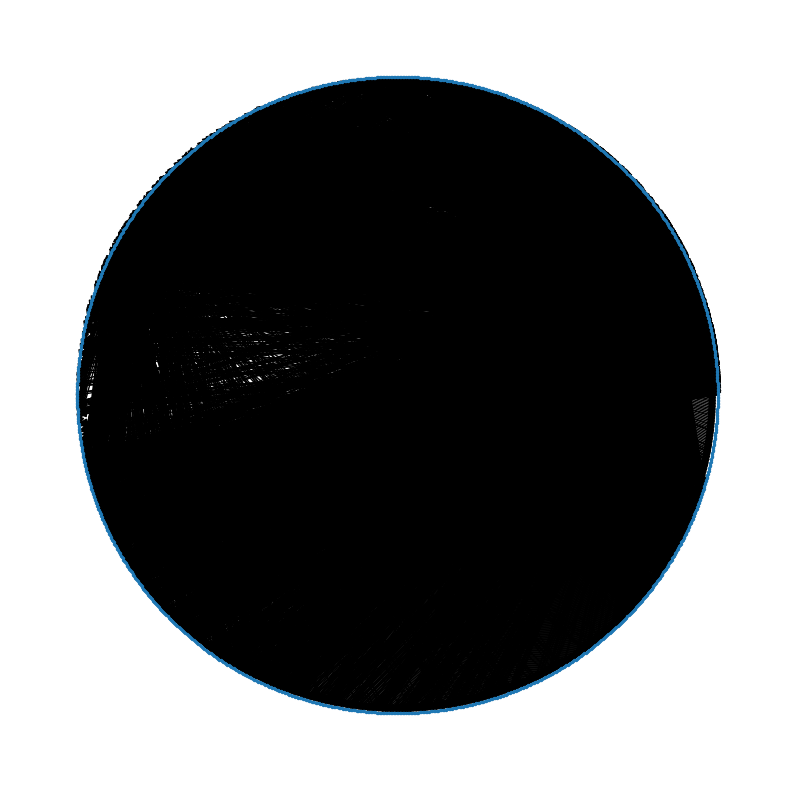

In [289]:
fig, ax = plt.subplots(figsize=(10, 10))

nx.draw(
    G, 
    pos=nx.circular_layout(G),
    node_size=2,
    alpha=1, 
    width=1,
    ax=ax
)   

#nx.draw(G, pos=nx.circular_layout(G), node_color='r', edge_color='b', ax=ax[1])


In [290]:
sparse_adj_matrix =nx.adjacency_matrix(G)

In [265]:
adj_matrix = nx.to_numpy_array(G)

In [264]:
import pickle

In [292]:
output = open('data/hci_social_followers.pkl', 'wb')
pickle.dump(followers_dict, output)

7898

In [ ]:
output = open('data/hci_social_following.pkl', 'wb')
pickle.dump(following_dict, output)

In [ ]:
output = open('data/sparse_adj_matrix.pkl', 'wb')
pickle.dump(sparse_adj_matrix, output)